In [204]:
# 引入需要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
#原始数据平稳性检验
from statsmodels.tsa.stattools import adfuller
# 读取数据集
df = pd.read_excel('./副本2022送电量.xlsx',sheet_name='Sheet2')
#根据时间排序
df = df.sort_values(by='date')
# 将date列转换成 Datetime 类型，并将其设置为索引列
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 计算去零后的均值
mean_value = df.loc[df['value'] != 0, 'value'].mean()
# 将0替换为去零后的均值
df['value'] = df['value'].replace(0, mean_value)
#检验时间序列数据的平稳性
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
# test_stationarity(df['value'])

## 当 p-value 值小于显著性水平（比如 5%）时，我们就可以否定原假设，也就是可以拒绝时间序列数据是非平稳的假设。因此，可以表示此时间序列在95% 的置信水平下是平稳的。
## 换句话就是时间序列数据是平稳的

# 1 上面是数据预处理：对原始时间序列进行平稳性检验（检验是否具有恒定的均值和方差），若不平稳，则需要对时间序列进行差分以实现平稳。常见的差分方式为一阶差分或二阶差分。若差分后序列仍不平稳，可以尝试对序列进行对数、平方根等变换。

In [205]:
# 拆分数据集为训练集和测试集
train = df[:'2023-09-30']
test = df['2023-10-01':]
train
# print(train.shape)
# print(test.shape)

,value
date,
2023-01-01,433.944000
2023-01-02,419.076000
2023-01-03,425.124000
2023-01-04,363.636000
2023-01-05,378.000000
...,...
2023-09-26,171.612000
2023-09-27,134.316000
2023-09-28,313.498049


/Users/bing/Desktop/网络与新媒体/projects/data_analysis/venv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


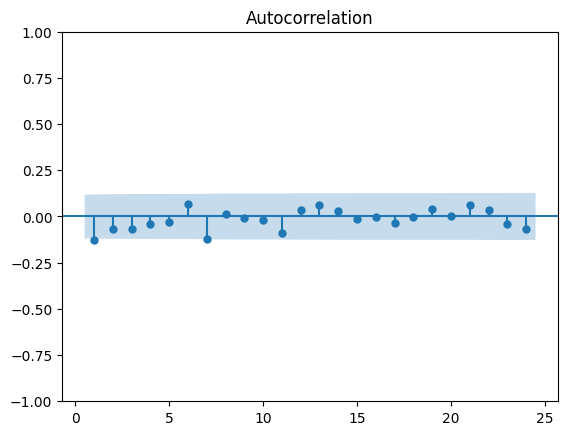

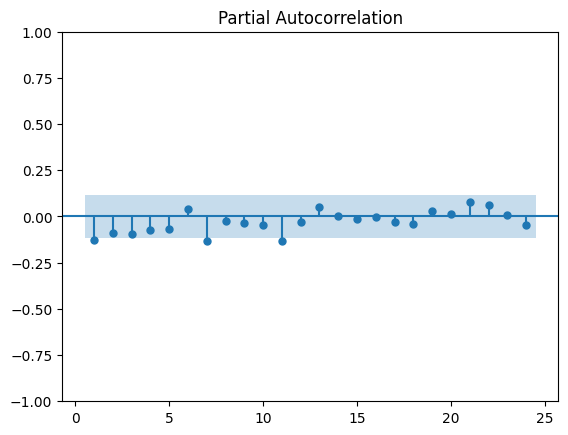

In [206]:
# 使用 ACF 和 PACF 图来选择 ARIMA 模型的参数
sm.graphics.tsa.plot_acf(train.diff().dropna(), lags=24, zero=False)
sm.graphics.tsa.plot_pacf(train.diff().dropna(), lags=24, zero=False)
plt.show()

这段代码展示了如何使用 ACF（自相关图）和 PACF（偏自相关图）来帮助选择 ARIMA 模型的参数。ACF 和 PACF 图可以展示时间序列数据的自相关性和偏相关性，根据这些图可以选择合适的 ARIMA 参数。下面解释一下代码：
sm.graphics.tsa.plot_acf() 和 sm.graphics.tsa.plot_pacf()分别用于绘制时间序列的自相关图和偏自相关图，其中train.diff()代表训练数据集的一阶差分（即用当前观察值减去前一个观察值）。
lags=参数指定要绘制的滞后阶数，这里设置为24；
zero=False指定不显示滞后为0的标记线；
最后，plt.show()语句则用于在屏幕上显示图表。

如果在ACF图中，ACF值在零线之上明显地截尾，而在其后的滞后点上则比较接近0，则表明该时序数据存在自相关性，可以考虑采用AR模型。在PACF上，如果拉格朗日数（Lag）上只有一个像样的高峰值，则很可能有一个AR模型适合数据。

如果在ACF上，截尾值在零线之下，而在其后的滞后点上则比较接近0，则表明该时序数据存在季节性自相关性，可以考虑使用SARIMA模型。在PACF上，随着拉格朗日数的增加，出现了明显的截尾现象，同时具有周期性波动，则表明SARIMA模型适合该数据。

如果在ACF和PACF上都存在显著的截尾现象，则表明数据是一种混合型的ARMA模型。
[如何根据自相关（ACF）图和偏自相关（PACF）图选择ARIMA模型的p、q值](https://blog.nowcoder.net/n/96cf91576b544214841df2e6f24545ba?from=nowcoder_improve)


In [207]:
# 引入需要的库
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


# 建立ARIMA模型
model = ARIMA(train, order=(5, 1, 2))
model_fit = model.fit()

# 输出模型概要信息
print(model_fit.summary())


/Users/bing/Desktop/网络与新媒体/projects/data_analysis/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/bing/Desktop/网络与新媒体/projects/data_analysis/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/bing/Desktop/网络与新媒体/projects/data_analysis/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  273
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -1424.163
Date:                Sun, 02 Apr 2023   AIC                           2864.326
Time:                        20:22:30   BIC                           2893.173
Sample:                    01-01-2023   HQIC                          2875.907
                         - 09-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7755      0.228     -3.406      0.001      -1.222      -0.329
ar.L2         -0.9387      0.215     -4.370      0.000      -1.360      -0.518
ar.L3         -0.2893      0.084     -3.455      0.0

创建了一个 ARIMA（1，1，1）模型，其中 train 是时间序列数据的训练集（通常是一阶差分后的数据），而 (1, 1, 1) 则指定了模型的三个参数：

p=1：表示时间序列模型中采用的自回归项（AR）的阶数，也就是过去若干时间点对当前时间点的影响，此处是1；
d=1：表示原始时间序列进行了几次差分（通常是1或2次差分），以消除时间序列的非平稳性，此处是1，表示进行了一次差分；
q=1：表示时间序列模型中采用的移动平均项（MA）的阶数，也就是过去若干误差对当前时间点的影响，此处是1。
在 ARIMA 的参数中，p 代表自回归阶数，d 代表差分阶数，q 代表移动平均阶数。这些参数的选取通常需要借助 ACF 和 PACF 图来进行辅助选择。在此例中，由于 ACF 和 PACF 图都表现出了自相关和偏相关显著的一阶差分序列，因此我们使用 ARIMA（1，1，1）模型来建模。

RMSE: 105.87156361666898


/Users/bing/Desktop/网络与新媒体/projects/data_analysis/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


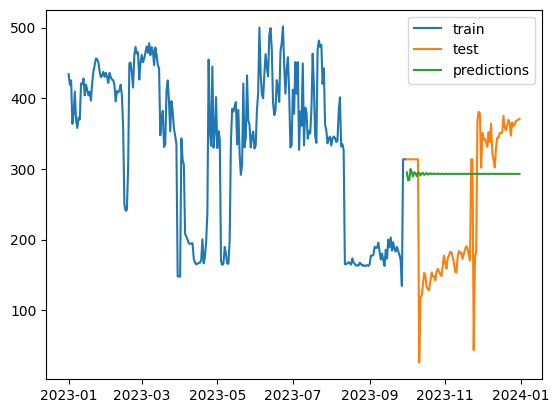

In [208]:
# 使用模型预测测试集
predictions = model_fit.predict(start='2023-10-01', end='2023-12-31')

# 计算模型性能指标
rmse = np.sqrt(mean_squared_error(test, predictions))
mape = np.mean(np.abs((test - predictions) / test)) * 100
print('RMSE:', rmse)
# print('MAPE:', mape)

# 可视化预测结果和原数据
plt.plot(train, label='train')
plt.plot(test, label='test')
plt.plot(predictions, label='predictions')
plt.legend(loc='best')
plt.show()


# 使用 GridSearchCV 进行模型参数调优

In [209]:
# 引入必要的库

from pmdarima.arima import ARIMA as pARIMA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# 数据
data = df

# 拆分数据集
train_size = int(len(data) * 0.7)
train = df[:'2023-09-30']
test = df['2023-10-01':]

# 建立ARIMA模型
model = pARIMA(order=(1, 1, 1))
model_fit = model.fit(train)

# 定义模型评估指标
def evaluate(model, X):
    # 拆分训练集和测试集
    train_size = int(len(X) * 0.7)
    train, test = X[0:train_size], X[train_size:]
    # 预测每个时间步
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        # 预测下一个时间步
        yhat = model.predict(n_periods=1)
        predictions.append(yhat[0])
        # 更新历史观测值
        history.append(test.iloc[t])
        model.update(test.iloc[t])
    # 计算 RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

# ARIMA参数范围
p = range(0, 3)    # 自回归项数目
d = range(0, 2)    # 差分次数
q = range(0, 3)    # 移动平均项数目
params = {'order':[(p_,d_,q_) for p_ in p for d_ in d for q_ in q]}

# 网格搜索
grid = GridSearchCV(model, params, scoring='neg_mean_squared_error')
grid.fit(train)
best_params = grid.best_params_
best_model = pARIMA(order=(best_params['order']))
best_model_fit = best_model.fit(train, disp=False)
rmse = evaluate(best_model_fit, test)
print('RMSE: %.3f' % rmse)
#打印最优参数
print('最优参数：', best_params)


/Users/bing/Desktop/网络与新媒体/projects/data_analysis/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/bing/Desktop/网络与新媒体/projects/data_analysis/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/bing/Desktop/网络与新媒体/projects/data_analysis/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/bing/Desktop/网络与新媒体/projects/data_analysis/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/bing/Desk

RMSE: 23.890
最优参数： {'order': (0, 0, 0)}


/Users/bing/Desktop/网络与新媒体/projects/data_analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/bing/Desktop/网络与新媒体/projects/data_analysis/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/bing/Desktop/网络与新媒体/projects/data_analysis/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/bing/Desktop/网络与新媒体/projects/data_analysis/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so 

# 获取最有参数以后，我们重新建立一次模型

In [210]:

# 定义模型评估指标
def evaluate(model, X):
    # 拆分训练集和测试集
    train_size = int(len(X) * 0.7)
    train, test = X[0:train_size], X[train_size:]
    # 预测每个时间步
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        # 预测下一个时间步
        yhat = model.predict(n_periods=1)
        predictions.append(yhat[0])
        # 更新历史观测值
        history.append(test[t])
        model.update(test[t])
    # 计算 RMSE
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

# 建立ARIMA模型
best_arima_model = pARIMA(order=best_params['order'])
best_arima_model_fit = best_arima_model.fit(train, disp=False)
# 使用最优模型评估RMSE得分
rmse = evaluate(best_arima_model_fit, test.values)
print('Test RMSE: %.3f' % rmse)

#预测数据
predictions = best_arima_model_fit.predict(start='2023-10-01', end='2023-12-31')
print(predictions)

Test RMSE: 23.890
[336.10872721 336.10872721 336.10872721 336.10872721 336.10872721
 336.10872721 336.10872721 336.10872721 336.10872721 336.10872721]


/Users/bing/Desktop/网络与新媒体/projects/data_analysis/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/bing/Desktop/网络与新媒体/projects/data_analysis/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [211]:
# 输出模型概要信息
print(best_arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  301
Model:                        SARIMAX   Log Likelihood               -1826.717
Date:                Sun, 02 Apr 2023   AIC                           3657.434
Time:                        20:22:34   BIC                           3664.849
Sample:                             0   HQIC                          3660.401
                                - 301                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    336.1087      7.250     46.363      0.000     321.900     350.318
sigma2      1.093e+04   1553.247      7.037      0.000    7885.689     1.4e+04
Ljung-Box (L1) (Q):                 250.33   Jarque-

In [213]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 加载数据
data = pd.read_excel('./副本2022送电量.xlsx',sheet_name='Sheet2')
#根据时间排序
data = data.sort_values(by='date')
# 将date列转换成 Datetime 类型，并将其设置为索引列
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# 计算去零后的均值
mean_value = df.loc[df['value'] != 0, 'value'].mean()
# 将0替换为去零后的均值
df['value'] = df['value'].replace(0, mean_value)
train_set = data.iloc[:250, 0:1].values
test_set = data.iloc[250:, 0:1].values

# 数据归一化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_set_scaled = scaler.fit_transform(train_set)

# 创建训练集数据和标签
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
look_back = 10
X_train, y_train = create_dataset(train_set_scaled, look_back)

# 调整输入数据的形状
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# 创建LSTM模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
model.fit(X_train, y_train, epochs=100, batch_size=32)

# 进行预测
inputs = data[len(data) - len(test_set) - look_back:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
X_test = []
for i in range(look_back, len(inputs)):
    X_test.append(inputs[i-look_back:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)

# 绘制预测结果
import matplotlib.pyplot as plt
plt.plot(test_set, color='red', label='Real data')
plt.plot(predicted, color='blue', label='Predicted data')
plt.title('LSTM Model')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 加载数据
data = pd.read_excel('./副本2022送电量.xlsx',sheet_name='Sheet2')
#根据时间排序
data = data.sort_values(by='date')
# 将date列转换成 Datetime 类型，并将其设置为索引列
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# 计算去零后的均值
mean_value = data.loc[data['value'] != 0, 'value'].mean()
# 将0替换为去零后的均值
data['value'] = data['value'].replace(0, mean_value)
train_set = data.iloc[:250, 0:1].values
test_set = data.iloc[250:, 0:1].values

# 数据归一化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_set_scaled = scaler.fit_transform(train_set)

# 创建训练集数据和标签
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
look_back = 10
X_train, y_train = create_dataset(train_set_scaled, look_back)

# 调整输入数据的形状
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# 创建LSTM模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
model.fit(X_train, y_train, epochs=100, batch_size=32)

# 进行预测
inputs = data[len(data) - len(test_set) - look_back:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
X_test = []
for i in range(look_back, len(inputs)):
    X_test.append(inputs[i-look_back:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)

# 绘制预测结果，x轴为对应的时间
import matplotlib.pyplot as plt
plt.plot(test_set, color='red', label='Real data')
plt.plot(predicted, color='blue', label='Predicted data')
plt.title('LSTM Model')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()
